In [2]:
import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from six.moves import cPickle as pickle
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

In [5]:
# notMNIST data
pkl_files = 'full_data.pickle'
with open(pkl_files, 'rb') as file:
    data = pickle.load(file)
    print(data['train_dataset'].shape)
    print(data['train_labels'].shape)
    print(data['valid_dataset'].shape)
    print(data['valid_labels'].shape)
    print(data['test_dataset'].shape)
    print(data['test_labels'].shape)

(45000, 28, 28)
(45000,)
(7000, 28, 28)
(7000,)
(1870, 28, 28)
(1870,)


In [3]:
# MNIST data
train_data = pd.read_csv('train.csv').values[:, 1:].reshape(-1, 28, 28)
test_data = pd.read_csv('test.csv').values.reshape(-1, 28, 28)
print(train_data.shape, test_data.shape)

(42000, 28, 28) (28000, 28, 28)


## Keras DCGAN

In [5]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(Activation('tanh'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model


def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5),padding='same', input_shape=(28, 28, 1)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [6]:
def generator_containing_discriminator(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

In [6]:
def train(BATCH_SIZE):
    X_train = train_data
    X_test = test_data
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    d_losses = []
    g_losses = []
    
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
    g.compile(loss='binary_crossentropy', optimizer="SGD")
    d_on_g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    for epoch in range(100):
        print("Epoch is", epoch)
        print("Number of batches", int(X_train.shape[0]/BATCH_SIZE))
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                Image.fromarray(image.astype(np.uint8)).save('images/' + str(epoch) + '_' + str(index) + '.png')
            X = np.concatenate((image_batch, generated_images))
            y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
            d_loss = d.train_on_batch(X, y)
#             print("batch %d d_loss : %f" % (index, d_loss))
            d_losses.append(d_loss)
            noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, [1] * BATCH_SIZE)
            d.trainable = True
#             print("batch %d g_loss : %f" % (index, g_loss))
            g_losses.append(g_loss)
            if index % 10 == 9:
                g.save_weights('generator', True)
                d.save_weights('discriminator', True)
    return np.array(d_losses), np.array(g_losses)

In [7]:
d_losses, g_losses = train(1000)

/opt/anaconda/envs/subaru/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch is 0
Number of batches 42
Epoch is 1
Number of batches 42
Epoch is 2
Number of batches 42
Epoch is 3
Number of batches 42
Epoch is 4
Number of batches 42
Epoch is 5
Number of batches 42
Epoch is 6
Number of batches 42
Epoch is 7
Number of batches 42
Epoch is 8
Number of batches 42
Epoch is 9
Number of batches 42
Epoch is 10
Number of batches 42
Epoch is 11
Number of batches 42
Epoch is 12
Number of batches 42
Epoch is 13
Number of batches 42
Epoch is 14
Number of batches 42
Epoch is 15
Number of batches 42
Epoch is 16
Number of batches 42
Epoch is 17
Number of batches 42
Epoch is 18
Number of batches 42
Epoch is 19
Number of batches 42
Epoch is 20
Number of batches 42
Epoch is 21
Number of batches 42
Epoch is 22
Number of batches 42
Epoch is 23
Number of batches 42
Epoch is 24
Number of batches 42
Epoch is 25
Number of batches 42
Epoch is 26
Number of batches 42
Epoch is 27
Number of batches 42
Epoch is 28
Number of batches 42
Epoch is 29
Number of batches 42
Epoch is 30
Number o

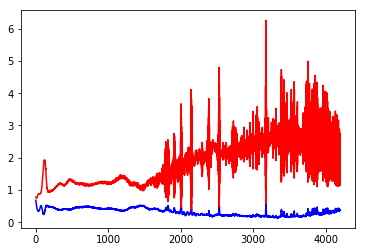

In [10]:
batches = np.array(range(4200))
plt.plot(batches, d_losses, c='blue')
plt.plot(batches, g_losses, c='red')
plt.show()

/opt/anaconda/envs/subaru/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  This is separate from the ipykernel package so we can avoid doing imports until


(1, 28, 28, 1)


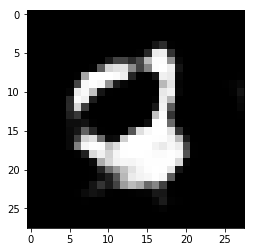

In [8]:
noise = np.random.uniform(-1, 1, size=(1, 100))
g = generator_model()
g.load_weights('generator')
test_sample = g.predict(noise, verbose=0)
print(test_sample.shape)
plt.imshow(test_sample.reshape(28, 28), cmap='gray')
plt.show()

## TensorFlow DCGAN

In [ ]:
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        # 1st hidden layer
        conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        o = tf.nn.tanh(conv5)

        return o
    
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # 1st hidden layer
        conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # 3rd hidden layer
        conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        # 4th hidden layer
        conv4 = tf.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        # output layer
        conv5 = tf.layers.conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        o = tf.nn.sigmoid(conv5)

        return o, conv5

In [ ]:
fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})
    if num_epoch == 20:
        pdb.set_trace()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k] * 255, (64, 64)), cmap='gray')

    label = 'Epoch' + str(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
# training parameters
batch_size = 100
lr = 0.0002
train_epoch = 20
steps = math.ceil(train_X.shape[0] // batch_size)

# variables : input
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1]))
                            )
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1]))
                            )
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                        (logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1]))
                       )

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [ ]:
# MNIST resize and normalization
x_input = tf.placeholder(tf.float32, shape=[None, 784])
x_reshaped = tf.reshape(x_input, [-1, 28, 28, 1])
train_set = tf.image.resize_images(x_reshaped, [64, 64]).eval(feed_dict={x_input: train_X})
train_set = (train_set - 0.5) / 0.5

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

In [ ]:
root = 'MNIST_DCGAN_results/'
model = 'MNIST_DCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

In [ ]:
# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for step in range(steps):
        # update discriminator
        batch_X, batch_y = next_batch(step, batch_size, train_set, train_y)
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: batch_X, z: z_, isTrain: True})
        D_losses.append(loss_d_)

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: batch_X, isTrain: True})
        G_losses.append(loss_g_)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - training time: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    #fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch + 1), save=False, show=True)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
#print("Training finish!... save training results")
#with open(root + model + 'train_hist.pkl', 'wb') as f:
#    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=False, show=True)

#images = []
#for e in range(train_epoch):
#    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
#    images.append(imageio.imread(img_name))
#imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

sess.close()